
Train a classifier on hand-made custom features

In [1]:
# https://ipython.org/ipython-doc/3/config/extensions/autoreload.html
%load_ext autoreload
%autoreload 2

In [2]:
import os 
import sys

root_path = os.path.abspath("..")
if root_path not in sys.path:
    sys.path.append(root_path)
    
import numpy as np
import matplotlib.pylab as plt
%matplotlib inline

from common.dataflow import get_train_df, get_test_df, get_image, get_target, get_inc_angle
from common.dataflow_visu_utils import display_image

In [3]:
train_df = get_train_df()
train_ships_df = train_df[train_df['is_iceberg'] == 0]
train_icebergs_df = train_df[train_df['is_iceberg'] == 1]

In [98]:
from common.imgproc_utils import *

In [118]:
def compute_mins_means_maxs(img):
    assert len(img.shape) == 3 and img.shape[2] == 2
    mins = [0.0, 0.0]
    maxs = [0.0, 0.0]
    means = [0.0, 0.0]
    for i in range(2):
        b = img[:, :, i]
        mins[i] = np.min(b)
        maxs[i] = np.max(b)
        means[i] = np.mean(b)  
    return mins, means, maxs


def count_and_mean_positive_signal(img):
    assert len(img.shape) == 3 and img.shape[2] == 2
    out = [0.0, 0.0]
    count = [0, 0]
    for i in range(2):
        b = img[:, :, i]
        b = b[b > 0]
        out[i] = np.mean(b) if len(b) > 0 else 0.0
        count[i] = len(b)
    return (*out, *count)


def compute_features(img, a):    
    mins, means, maxs = compute_mins_means_maxs(img)
#     diff = [mx - mn for mn, mx in zip(means, maxs)]
    ret = count_and_mean_positive_signal(img)    
    obj_per_band = segment_object_per_band(img)
    obj_size_per_band = np.count_nonzero(obj_per_band[:, :, 0]), np.count_nonzero(obj_per_band[:, :, 1])
    obj_size = object_size(img)
    
    return (*means, *maxs, *ret, obj_size, *obj_size_per_band, a)

(-16.668413,
 -26.578093,
 0.855726,
 -20.23761,
 0.33497986,
 0.0,
 6,
 0,
 2,
 399,
 23,
 42.537599999999998)

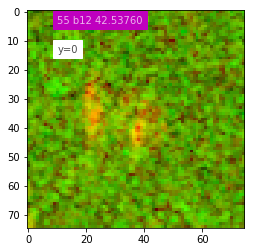

In [119]:
index = train_df.index[55]
img = get_image(index, train_df)
a = get_inc_angle(index, train_df)
y = get_target(index, train_df)

plt.figure(figsize=(12, 4))
ax = plt.subplot(111)
display_image(ax, img, index, 'b12', a, target=y)
compute_features(img, a)

In [120]:
train_df.loc[train_df.index[55], :]

band_1        [-20.080898, -21.047037, -22.329433, -23.60285...
band_2        [-25.371161999999998, -27.239639, -30.589506, ...
id                                                     28de1d17
inc_angle                                               42.5376
is_iceberg                                                    0
Name: 55, dtype: object

Prepare data

In [121]:
features = np.zeros((len(train_df), 12))
for i, index in enumerate(train_df.index):
    img = get_image(index, train_df)
    a = get_inc_angle(index, train_df)
    features[i, :] = compute_features(img, a)

targets = train_df['is_iceberg'].values                  

In [122]:
import xgboost as xgb

In [123]:
dtrainval = xgb.DMatrix(features, label=targets)

Boosting

In [124]:
seed = 12345
n_folds = 7

params = {
    "objective": "binary:logistic",
    "booster": "gbtree",
    "eval_metric": "logloss",
    "eta": None,
    "tree_method": 'auto',
    "max_depth": None,
    "subsample": None,
    "colsample_bytree": None,
    "silent": 1,
    "seed": None,
}

best_params = {
    'test-%s-mean' % params['eval_metric']: 1e10,
    'params': {},
    'num_boost_round': 0
}

# Search for the best parameters using CV
def generate_params():
    eta = np.random.uniform(0.05, 0.001)
    max_depth = np.random.randint(2, 4)
    subsample = np.random.uniform(0.5, 0.95)
    colsample_bytree = np.random.uniform(0.5, 0.95)
    return eta, max_depth, subsample, colsample_bytree

In [125]:
np.random.seed(seed)
for i in range(100):

    eta, max_depth, subsample, colsample_bytree = generate_params()
    i += 1
    seed += i - 1
    print('\n{} : XGBoost params. ETA: {}, MAX_DEPTH: {}, SUBSAMPLE: {}, COLSAMPLE_BY_TREE: {}'
          .format(i, eta, max_depth, subsample, colsample_bytree))
    num_boost_round = 50000
    early_stopping_rounds = 500

    params['eta'] = eta
    params['max_depth'] = max_depth
    params['subsample'] = subsample
    params['colsample_bytree'] = colsample_bytree
    params['seed'] = seed

    cvresult = xgb.cv(params, dtrain=dtrainval,
                      seed=params['seed'],
                      num_boost_round=num_boost_round,
                      early_stopping_rounds=early_stopping_rounds,
                      nfold=n_folds,
                      stratified=True,
                      verbose_eval=early_stopping_rounds)

    min_test_eval_metric_mean = cvresult['test-%s-mean' % params['eval_metric']].min()
    if best_params['test-%s-mean' % params['eval_metric']] > min_test_eval_metric_mean:
        best_params['test-%s-mean' % params['eval_metric']] = min_test_eval_metric_mean
        best_params['params'] = params
        best_params['num_boost_round'] = len(cvresult)
        print("Best cv result: ", cvresult.loc[cvresult.index[-1], :])
        print("Best params: ", params)


1 : XGBoost params. ETA: 0.04251947698983522, MAX_DEPTH: 3, SUBSAMPLE: 0.5903268119537561, COLSAMPLE_BY_TREE: 0.7863144312570777
[0]	train-logloss:0.677409+0.00175099	test-logloss:0.678423+0.00221827
[500]	train-logloss:0.125171+0.00523811	test-logloss:0.282441+0.0323931
[1000]	train-logloss:0.0630572+0.0037134	test-logloss:0.285794+0.0353521
Best cv result:  test-logloss-mean     0.281842
test-logloss-std      0.033649
train-logloss-mean    0.120252
train-logloss-std     0.005100
Name: 525, dtype: float64
Best params:  {'eta': 0.04251947698983522, 'subsample': 0.5903268119537561, 'objective': 'binary:logistic', 'tree_method': 'auto', 'max_depth': 3, 'booster': 'gbtree', 'silent': 1, 'eval_metric': 'logloss', 'colsample_bytree': 0.7863144312570777, 'seed': 777}

2 : XGBoost params. ETA: 0.04251947698983522, MAX_DEPTH: 3, SUBSAMPLE: 0.5903268119537561, COLSAMPLE_BY_TREE: 0.7863144312570777
[0]	train-logloss:0.676137+0.000431683	test-logloss:0.676818+0.00140272
[500]	train-logloss:0.124

[3000]	train-logloss:0.257693+0.00937156	test-logloss:0.322856+0.0389789
[3500]	train-logloss:0.241506+0.00930406	test-logloss:0.314434+0.0405041
[4000]	train-logloss:0.227649+0.00917108	test-logloss:0.308303+0.0423997
[4500]	train-logloss:0.215377+0.00891252	test-logloss:0.303278+0.0438585
[5000]	train-logloss:0.204593+0.00880753	test-logloss:0.299496+0.045128
[5500]	train-logloss:0.194807+0.00866732	test-logloss:0.296572+0.046395
[6000]	train-logloss:0.185945+0.00846079	test-logloss:0.29409+0.0470895
[6500]	train-logloss:0.177752+0.0083061	test-logloss:0.292196+0.0480496
[7000]	train-logloss:0.170217+0.00807222	test-logloss:0.291007+0.0489232
[7500]	train-logloss:0.163227+0.00780667	test-logloss:0.289895+0.049875
[8000]	train-logloss:0.156744+0.00756103	test-logloss:0.288729+0.0505778
[8500]	train-logloss:0.150626+0.00733131	test-logloss:0.2882+0.0513867
[9000]	train-logloss:0.144843+0.00720555	test-logloss:0.287383+0.0517462
[9500]	train-logloss:0.139375+0.00707704	test-logloss:0.28

[500]	train-logloss:0.121793+0.005114	test-logloss:0.280666+0.0399746
[1000]	train-logloss:0.0613272+0.00326822	test-logloss:0.287703+0.0446411

22 : XGBoost params. ETA: 0.03010751281379133, MAX_DEPTH: 3, SUBSAMPLE: 0.9063769511542447, COLSAMPLE_BY_TREE: 0.7065942574784767
[0]	train-logloss:0.681273+0.00049077	test-logloss:0.681842+0.000484111
[500]	train-logloss:0.164726+0.00656723	test-logloss:0.28727+0.0286997
[1000]	train-logloss:0.0917862+0.00421638	test-logloss:0.275121+0.036971
[1500]	train-logloss:0.057076+0.00283245	test-logloss:0.276148+0.0442698

23 : XGBoost params. ETA: 0.019913875903058757, MAX_DEPTH: 3, SUBSAMPLE: 0.8281255395316299, COLSAMPLE_BY_TREE: 0.7959375908776816
[0]	train-logloss:0.686268+0.000569006	test-logloss:0.686904+0.000757988
[500]	train-logloss:0.204971+0.00735232	test-logloss:0.30605+0.044605
[1000]	train-logloss:0.131151+0.00585714	test-logloss:0.285748+0.0528631
[1500]	train-logloss:0.0899312+0.00514457	test-logloss:0.279987+0.059888
[2000]	train-lo

[500]	train-logloss:0.253145+0.003605	test-logloss:0.316515+0.0140495
[1000]	train-logloss:0.19123+0.00334167	test-logloss:0.301458+0.0162952
[1500]	train-logloss:0.15494+0.00274976	test-logloss:0.296528+0.0167437

38 : XGBoost params. ETA: 0.018048513371012306, MAX_DEPTH: 2, SUBSAMPLE: 0.9078257560497409, COLSAMPLE_BY_TREE: 0.5651446505793991
[0]	train-logloss:0.688307+6.04933e-05	test-logloss:0.688476+0.000411601
[500]	train-logloss:0.2893+0.00307656	test-logloss:0.337776+0.0120388
[1000]	train-logloss:0.224659+0.00318947	test-logloss:0.304123+0.0129344
[1500]	train-logloss:0.185846+0.00236906	test-logloss:0.291465+0.0138555
[2000]	train-logloss:0.156718+0.00201449	test-logloss:0.285198+0.0140744
[2500]	train-logloss:0.134183+0.00198732	test-logloss:0.280907+0.0149661
[3000]	train-logloss:0.116075+0.001609	test-logloss:0.277906+0.0155861
[3500]	train-logloss:0.101335+0.001699	test-logloss:0.276252+0.0165651
[4000]	train-logloss:0.0889312+0.00187906	test-logloss:0.274668+0.0162846
[45

[1500]	train-logloss:0.094161+0.00277458	test-logloss:0.285116+0.0332686

49 : XGBoost params. ETA: 0.03386214636870369, MAX_DEPTH: 3, SUBSAMPLE: 0.9161450839979419, COLSAMPLE_BY_TREE: 0.7471283463076391
[0]	train-logloss:0.680225+0.00105873	test-logloss:0.681241+0.000937762
[500]	train-logloss:0.153334+0.00503717	test-logloss:0.282019+0.0257691
[1000]	train-logloss:0.0817484+0.00472523	test-logloss:0.269985+0.0359403
[1500]	train-logloss:0.0492984+0.00316706	test-logloss:0.274443+0.0476427

50 : XGBoost params. ETA: 0.0025347485061917585, MAX_DEPTH: 2, SUBSAMPLE: 0.5850369924632858, COLSAMPLE_BY_TREE: 0.7732195360948857
[0]	train-logloss:0.692365+4.62671e-05	test-logloss:0.692395+0.000129546
[500]	train-logloss:0.491612+0.00502331	test-logloss:0.502444+0.0125286
[1000]	train-logloss:0.416048+0.00622929	test-logloss:0.436303+0.0174391
[1500]	train-logloss:0.370566+0.0060418	test-logloss:0.398482+0.0198257
[2000]	train-logloss:0.338554+0.00599198	test-logloss:0.373236+0.0212501
[2500]	t

[5500]	train-logloss:0.186472+0.00737174	test-logloss:0.292717+0.0315966
[6000]	train-logloss:0.177899+0.0073501	test-logloss:0.290564+0.0322016
[6500]	train-logloss:0.170027+0.00734455	test-logloss:0.28887+0.0326192
[7000]	train-logloss:0.1625+0.00726903	test-logloss:0.286907+0.0329833
[7500]	train-logloss:0.155516+0.00707608	test-logloss:0.285609+0.0333839
[8000]	train-logloss:0.149039+0.00689191	test-logloss:0.284325+0.0339912
[8500]	train-logloss:0.142947+0.00678608	test-logloss:0.283543+0.0342847
[9000]	train-logloss:0.137219+0.00659341	test-logloss:0.282482+0.0350455
[9500]	train-logloss:0.131768+0.00645307	test-logloss:0.28147+0.0353829
[10000]	train-logloss:0.12661+0.00629871	test-logloss:0.280751+0.0357487
[10500]	train-logloss:0.121876+0.00623551	test-logloss:0.280533+0.0360426
[11000]	train-logloss:0.117337+0.00607366	test-logloss:0.280138+0.0365138
[11500]	train-logloss:0.113006+0.0059566	test-logloss:0.280165+0.0371252
[12000]	train-logloss:0.108908+0.00583683	test-logloss

[41500]	train-logloss:0.111823+0.00459821	test-logloss:0.269797+0.0427318
[42000]	train-logloss:0.110685+0.00457288	test-logloss:0.269715+0.0428903
[42500]	train-logloss:0.109567+0.00453902	test-logloss:0.269635+0.042989
[43000]	train-logloss:0.108443+0.00449838	test-logloss:0.269562+0.0430327
[43500]	train-logloss:0.107346+0.00446464	test-logloss:0.269502+0.0432265
[44000]	train-logloss:0.106268+0.00444447	test-logloss:0.269491+0.0433037
[44500]	train-logloss:0.105208+0.00440423	test-logloss:0.269476+0.0434353

62 : XGBoost params. ETA: 0.0305256613543672, MAX_DEPTH: 3, SUBSAMPLE: 0.7496862848278785, COLSAMPLE_BY_TREE: 0.6131985955251882
[0]	train-logloss:0.681521+0.000712793	test-logloss:0.682747+0.00129034
[500]	train-logloss:0.163422+0.0083345	test-logloss:0.292559+0.0368012
[1000]	train-logloss:0.0918434+0.00556443	test-logloss:0.285647+0.0438278

63 : XGBoost params. ETA: 0.0397755329901766, MAX_DEPTH: 3, SUBSAMPLE: 0.81452218377045, COLSAMPLE_BY_TREE: 0.5709587951326669
[0]	trai

[1000]	train-logloss:0.179597+0.0102355	test-logloss:0.292528+0.04429
[1500]	train-logloss:0.136633+0.00931994	test-logloss:0.283178+0.0502104
[2000]	train-logloss:0.10651+0.00785587	test-logloss:0.276288+0.0552061
[2500]	train-logloss:0.0846176+0.00686664	test-logloss:0.272027+0.0600452
[3000]	train-logloss:0.0685604+0.00585676	test-logloss:0.271631+0.0649231

74 : XGBoost params. ETA: 0.01809962242444256, MAX_DEPTH: 2, SUBSAMPLE: 0.683226933515622, COLSAMPLE_BY_TREE: 0.8562656731844114
[0]	train-logloss:0.687042+0.00015182	test-logloss:0.687273+0.000422477
[500]	train-logloss:0.278814+0.0027411	test-logloss:0.32822+0.0126763
[1000]	train-logloss:0.213801+0.00275983	test-logloss:0.297181+0.013243
[1500]	train-logloss:0.175133+0.00283858	test-logloss:0.287442+0.017256
[2000]	train-logloss:0.147638+0.00296184	test-logloss:0.284212+0.0206063
[2500]	train-logloss:0.126346+0.00303861	test-logloss:0.281786+0.0229924
[3000]	train-logloss:0.109449+0.00278878	test-logloss:0.281659+0.0251047

7

[1500]	train-logloss:0.0716126+0.00330102	test-logloss:0.277872+0.0350722

89 : XGBoost params. ETA: 0.037100285144197186, MAX_DEPTH: 2, SUBSAMPLE: 0.8476454557882904, COLSAMPLE_BY_TREE: 0.5064866119694319
[0]	train-logloss:0.682212+0.000685539	test-logloss:0.682474+0.00063078
[500]	train-logloss:0.220664+0.00646793	test-logloss:0.309092+0.0267212
[1000]	train-logloss:0.152499+0.00495297	test-logloss:0.289317+0.0324113
[1500]	train-logloss:0.112387+0.00471855	test-logloss:0.285829+0.0361931
[2000]	train-logloss:0.0857226+0.00358161	test-logloss:0.286951+0.0406308

90 : XGBoost params. ETA: 0.04941636084866725, MAX_DEPTH: 2, SUBSAMPLE: 0.5320619066372401, COLSAMPLE_BY_TREE: 0.548014909523595
[0]	train-logloss:0.678998+0.000973125	test-logloss:0.679123+0.00122269
[500]	train-logloss:0.195104+0.00476491	test-logloss:0.298793+0.0180992
[1000]	train-logloss:0.132158+0.00431063	test-logloss:0.295309+0.0222655

91 : XGBoost params. ETA: 0.02977095895381452, MAX_DEPTH: 3, SUBSAMPLE: 0.73714286

In [126]:
best_params

{'num_boost_round': 4430,
 'params': {'booster': 'gbtree',
  'colsample_bytree': 0.7645486555506023,
  'eta': 0.04243490693574713,
  'eval_metric': 'logloss',
  'max_depth': 2,
  'objective': 'binary:logistic',
  'seed': 5727,
  'silent': 1,
  'subsample': 0.5434422736524103,
  'tree_method': 'auto'},
 'test-logloss-mean': 0.25865359999999998}

```
{'num_boost_round': 1199,
 'params': {'booster': 'gbtree',
  'colsample_bytree': 0.7694962178891804,
  'eta': 0.0380695624105211,
  'eval_metric': 'logloss',
  'max_depth': 2,
  'objective': 'binary:logistic',
  'seed': 12727,
  'silent': 1,
  'subsample': 0.5690285270194964,
  'tree_method': 'auto'},
 'test-logloss-mean': 0.26314800000000005}
```

Train model

In [127]:
# Train model
dtrain = xgb.DMatrix(features, label=targets)
model = xgb.train(best_params['params'],
                  dtrain,
                  num_boost_round=best_params['num_boost_round'],
                  evals=[(dtrain, 'train')], 
                  verbose_eval=500)


[0]	train-logloss:0.678962
[500]	train-logloss:0.211468
[1000]	train-logloss:0.149473
[1500]	train-logloss:0.112104
[2000]	train-logloss:0.088141
[2500]	train-logloss:0.071603
[3000]	train-logloss:0.058744
[3500]	train-logloss:0.048941
[4000]	train-logloss:0.041278


In [128]:
model.get_fscore()

{'f0': 1548,
 'f1': 1525,
 'f10': 1216,
 'f11': 2497,
 'f2': 1451,
 'f3': 1615,
 'f4': 437,
 'f5': 6,
 'f6': 200,
 'f7': 4,
 'f8': 1084,
 'f9': 1406}

Make predictions

In [129]:
test_df = get_test_df()

test_features = np.zeros((len(test_df), 12))
for i, index in enumerate(test_df.index):
    img = get_image(index, test_df)
    a = get_inc_angle(index, test_df)
    test_features[i, :] = compute_features(img, a)

data_ids = test_df['id'].values    

In [131]:
dtest = xgb.DMatrix(test_features)

In [134]:
y_probas = model.predict(dtest)
y_probas2 = y_probas[:, None]
y_probas2 = np.concatenate((y_probas2, y_probas2), axis=1)

In [136]:
from common import write_submission

In [146]:
output_filename = os.path.join("..", "results", "submission__xbg_12_features_val=0.258.csv")
write_submission(output_filename, y_probas2)